# MNIST Basic Classifier

## Imports and Data Loading

In [1]:
from __future__ import print_function
import numpy as np
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# batchsize init
batchsize = 64
loginterval=10

SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()

#device = torch.device("cuda" if cuda else "cpu")
cuda=False
device = torch.device("cpu")

# definition of the dataloaders

kwargs = {'num_workers': 4, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

## Model Definiton

The model considered is a very basic fuly connected network with one hidden layer of 1000 neurons.

In [2]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=1)    


model = Model()

if cuda:
    model.cuda()


optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Train and Test over epochs

In [3]:
EPOCHS = 5
losses = []

# Eval
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
train_size = len(train_loader.dataset)
batch_size = (train_size / 256) if (cuda) else  (train_size / 64)

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')

    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 GeForce GT 630M which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.038585	 Test Accuracy: 96.5800%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.042661	 Test Accuracy: 97.5800%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.005757	 Test Accuracy: 97.9600%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.032870	 Test Accuracy: 97.7800%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.010316	 Test Accuracy: 98.1000%


In [4]:
model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().item()/d.size()[0]
print('Accuracy:', accuracy*100)

Accuracy: 98.1


## Losses Evolution

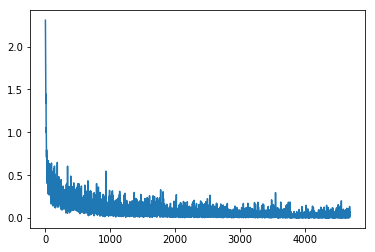

In [5]:
plt.plot(losses)

## Model Saving

In [6]:
torch.save(model.state_dict(), '../mnist_classifier.pth')